Loaded preprocessor with 25 expanded features
✔ X_test loaded from: X_test_binary.csv
✔ y_test loaded from: y_test_binary.npy
X_test shape: (600, 65)
y_test shape: (600,)


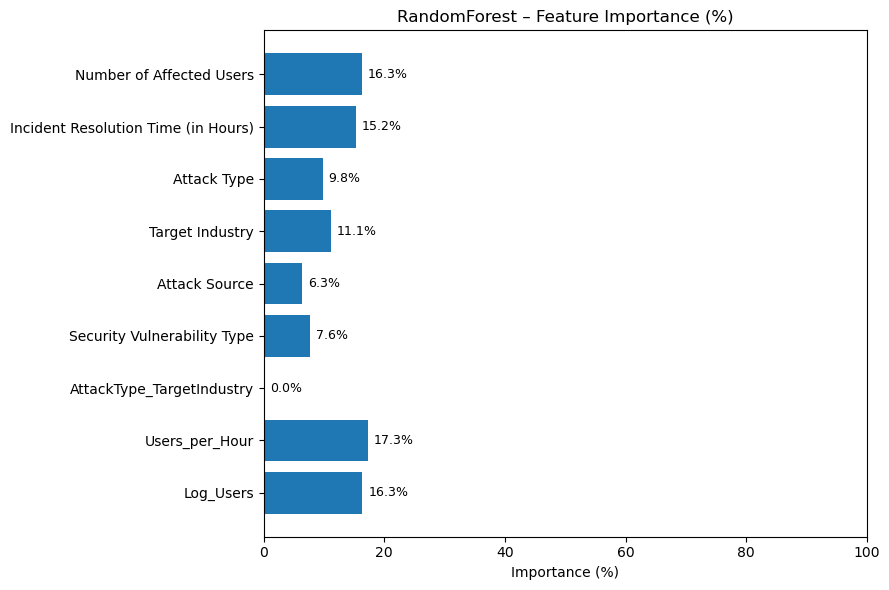

In [9]:
# =====================================================
# Cell 1: Setup (FULLY FIXED)
# =====================================================
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# BASE PROJECT PATH (FIX ONCE)
# ---------------------------
BASE_DIR = r"C:\Users\uthay\Desktop\CyberThreats_FinancialLoss_Prediction_ML_Final_Project"

MODEL_PATH = os.path.join(BASE_DIR, "models")
PROCESSED_PATH = os.path.join(BASE_DIR, "data", "processed")

# ---------------------------
# Business-level features
# ---------------------------
main_features = [
    "Number of Affected Users",
    "Incident Resolution Time (in Hours)",
    "Attack Type",
    "Target Industry",
    "Attack Source",
    "Security Vulnerability Type",
    "AttackType_TargetIndustry",
    "Users_per_Hour",
    "Log_Users"
]

# =====================================================
# Safe loaders (AUTO-DETECT FILES)
# =====================================================
def load_X_test(path):
    for f in os.listdir(path):
        if f.lower().startswith("x_test") and f.lower().endswith(".csv"):
            print(f"✔ X_test loaded from: {f}")
            return pd.read_csv(os.path.join(path, f))
    raise FileNotFoundError("❌ X_test CSV not found in processed folder")

def load_y_test(path):
    for f in os.listdir(path):
        if f.lower().startswith("y_test") and f.lower().endswith(".npy"):
            print(f"✔ y_test loaded from: {f}")
            return np.load(os.path.join(path, f), allow_pickle=True).astype(int)
    raise FileNotFoundError("❌ y_test NPY not found in processed folder")

# =====================================================
# Load preprocessor
# =====================================================
preprocessor_path = os.path.join(MODEL_PATH, "preprocessor_step4_binary.joblib")
if not os.path.exists(preprocessor_path):
    raise FileNotFoundError(f"Missing preprocessor: {preprocessor_path}")

preprocessor = joblib.load(preprocessor_path)
expanded_names = list(preprocessor.get_feature_names_out())
print(f"Loaded preprocessor with {len(expanded_names)} expanded features")

# =====================================================
# Load test data
# =====================================================
X_test_df = load_X_test(PROCESSED_PATH)
y_test = load_y_test(PROCESSED_PATH)

print("X_test shape:", X_test_df.shape)
print("y_test shape:", y_test.shape)

# =====================================================
# Feature importance helpers
# =====================================================
def get_raw_importances(model, expanded_names, X_df=None, y=None):
    n = len(expanded_names)

    # Tree-based (RF, XGB)
    if hasattr(model, "feature_importances_"):
        arr = np.asarray(model.feature_importances_, dtype=float)
        return np.pad(arr, (0, max(0, n - arr.size)))[:n]

    # CatBoost
    if hasattr(model, "get_feature_importance"):
        try:
            arr = np.asarray(model.get_feature_importance(), dtype=float)
            return np.pad(arr, (0, max(0, n - arr.size)))[:n]
        except Exception:
            pass

    # Permutation fallback
    perm = permutation_importance(
        model,
        X_df,
        y,
        n_repeats=8,
        random_state=42,
        n_jobs=-1,
        scoring="f1_macro"
    )
    return perm.importances_mean


def aggregate_to_main(raw_imp, expanded_names, main_features):
    agg = {}
    for feat in main_features:
        idx = [
            i for i, f in enumerate(expanded_names)
            if feat in f
        ]
        agg[feat] = float(np.sum(raw_imp[idx])) if idx else 0.0
    return pd.Series(agg, index=main_features)

# =====================================================
# Cell 2: RandomForest Feature Importance
# =====================================================
model_name = "RandomForest"
model_file = "RandomForest_step4_binary_prob_tuned.joblib"
model_path = os.path.join(MODEL_PATH, model_file)

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found: {model_path}")

model = joblib.load(model_path)

# ---------------------------
# Compute importance
# ---------------------------
raw_imp = get_raw_importances(model, expanded_names, X_test_df, y_test)
agg_imp = aggregate_to_main(raw_imp, expanded_names, main_features)

# Normalize to %
total = agg_imp.sum()
perc = (agg_imp / total * 100) if total > 0 else np.full(len(agg_imp), 100 / len(agg_imp))

# =====================================================
# Plot (Professional Style)
# =====================================================
plt.figure(figsize=(9, 6))
plt.barh(agg_imp.index, perc)
plt.title(f"{model_name} – Feature Importance (%)")
plt.xlabel("Importance (%)")
plt.xlim(0, 100)
plt.gca().invert_yaxis()

for i, v in enumerate(perc):
    plt.text(v + 1, i, f"{v:.1f}%", va="center", fontsize=9)

plt.tight_layout()
plt.show()


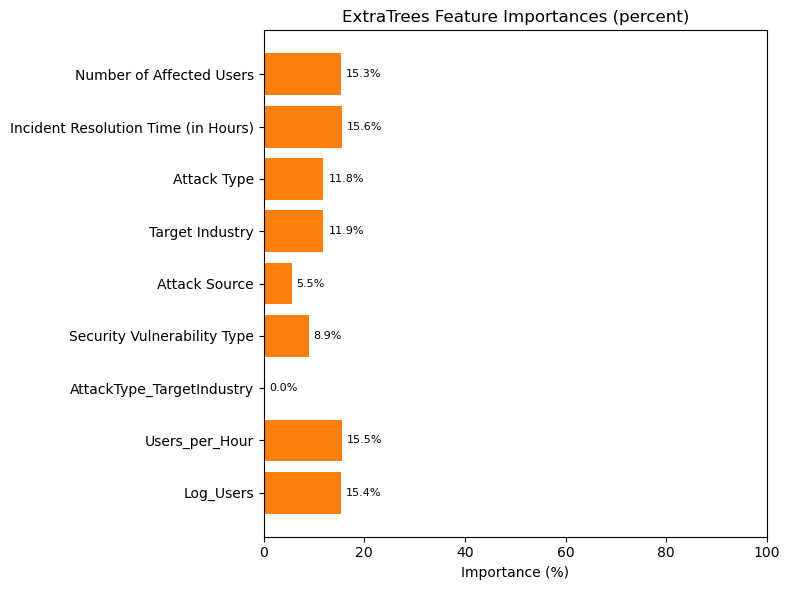

In [10]:
# Cell 3: ExtraTrees Feature Importances
model_name = "ExtraTrees"
model_file = "ExtraTrees_step4_binary_prob_tuned.joblib"
model = joblib.load(os.path.join(MODEL_PATH, model_file))

raw_imp = get_raw_importances(model, expanded_names, X_test_df, y_test)
agg = aggregate_to_main(raw_imp, expanded_names, main_features)

s = agg.sum()
vals = (agg / s * 100) if s > 0 else np.full(len(agg), 100/len(agg))

plt.figure(figsize=(8,6))
plt.barh(agg.index, vals, color='C1')
plt.title(f"{model_name} Feature Importances (percent)")
plt.xlim(0, 100)
plt.gca().invert_yaxis()
for y_pos, v in enumerate(vals):
    plt.text(v + 1.0, y_pos, f"{v:.1f}%", va='center', fontsize=8)
plt.xlabel("Importance (%)")
plt.tight_layout()
plt.show()


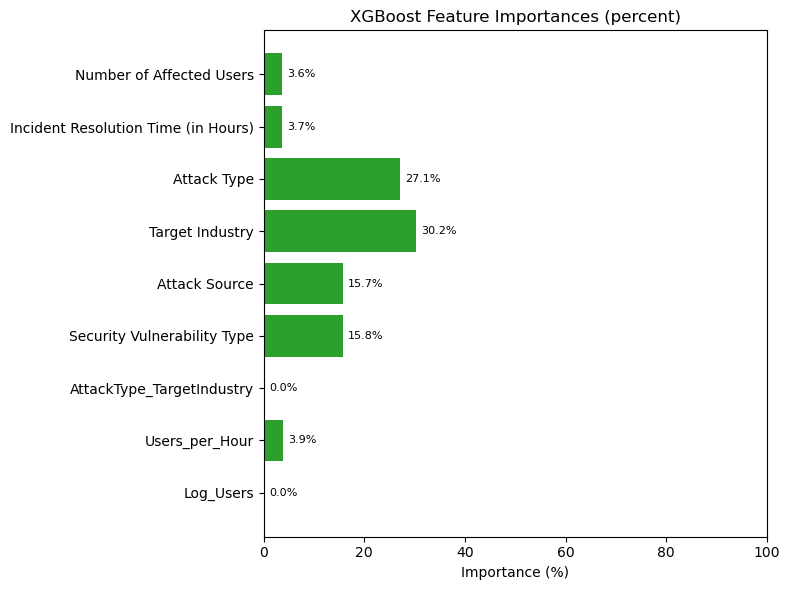

In [11]:
# Cell 4: XGBoost Feature Importances
model_name = "XGBoost"
model_file = "XGBoost_step4_binary_prob_tuned.joblib"
model = joblib.load(os.path.join(MODEL_PATH, model_file))

raw_imp = get_raw_importances(model, expanded_names, X_test_df, y_test)
agg = aggregate_to_main(raw_imp, expanded_names, main_features)

s = agg.sum()
vals = (agg / s * 100) if s > 0 else np.full(len(agg), 100/len(agg))

plt.figure(figsize=(8,6))
plt.barh(agg.index, vals, color='C2')
plt.title(f"{model_name} Feature Importances (percent)")
plt.xlim(0, 100)
plt.gca().invert_yaxis()
for y_pos, v in enumerate(vals):
    plt.text(v + 1.0, y_pos, f"{v:.1f}%", va='center', fontsize=8)
plt.xlabel("Importance (%)")
plt.tight_layout()
plt.show()


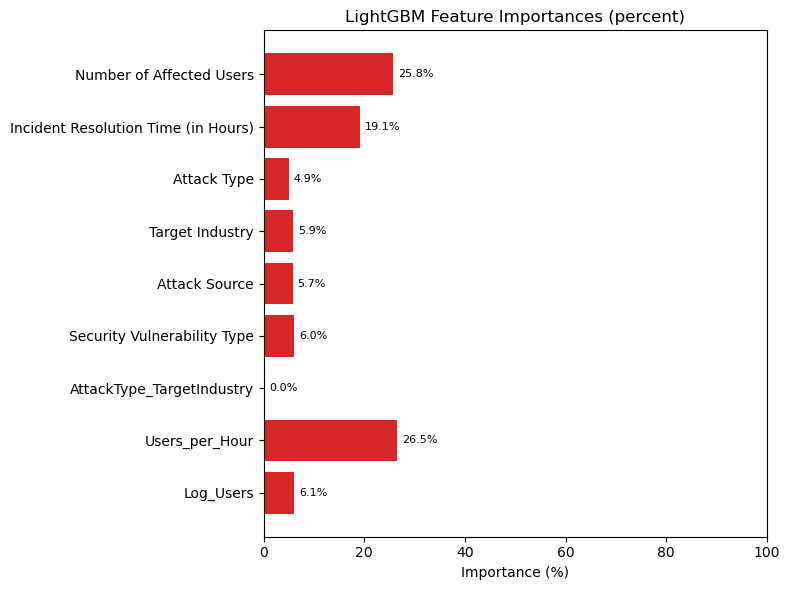

In [12]:
# Cell 5: LightGBM Feature Importances
model_name = "LightGBM"
model_file = "LightGBM_step4_binary_prob_tuned.joblib"
model = joblib.load(os.path.join(MODEL_PATH, model_file))

raw_imp = get_raw_importances(model, expanded_names, X_test_df, y_test)
agg = aggregate_to_main(raw_imp, expanded_names, main_features)

s = agg.sum()
vals = (agg / s * 100) if s > 0 else np.full(len(agg), 100/len(agg))

plt.figure(figsize=(8,6))
plt.barh(agg.index, vals, color='C3')
plt.title(f"{model_name} Feature Importances (percent)")
plt.xlim(0, 100)
plt.gca().invert_yaxis()
for y_pos, v in enumerate(vals):
    plt.text(v + 1.0, y_pos, f"{v:.1f}%", va='center', fontsize=8)
plt.xlabel("Importance (%)")
plt.tight_layout()
plt.show()


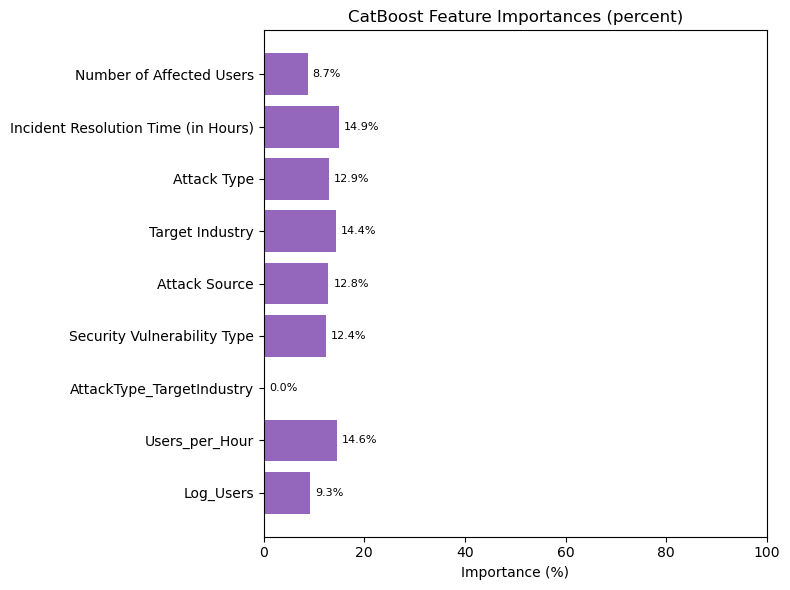

In [13]:
# Cell 6: CatBoost Feature Importances
model_name = "CatBoost"
model_file = "CatBoost_step4_binary_prob_tuned.joblib"
model = joblib.load(os.path.join(MODEL_PATH, model_file))

raw_imp = get_raw_importances(model, expanded_names, X_test_df, y_test)
agg = aggregate_to_main(raw_imp, expanded_names, main_features)

s = agg.sum()
vals = (agg / s * 100) if s > 0 else np.full(len(agg), 100/len(agg))

plt.figure(figsize=(8,6))
plt.barh(agg.index, vals, color='C4')
plt.title(f"{model_name} Feature Importances (percent)")
plt.xlim(0, 100)
plt.gca().invert_yaxis()
for y_pos, v in enumerate(vals):
    plt.text(v + 1.0, y_pos, f"{v:.1f}%", va='center', fontsize=8)
plt.xlabel("Importance (%)")
plt.tight_layout()
plt.show()
